# データ解析特論 2022年度水曜２限

# 第10回 その2 カーネルSVMで非線形分離

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_moons

## データ

`sklearn.datasets` に入っている `make_moons` にノイズを足したデータは線形分離できない．これをカーネルSVMを使って非線形分離しよう．

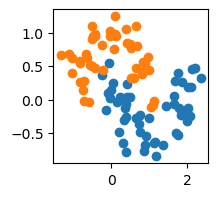

In [7]:
# データサイズ
N = 100

# seed
np.random.seed(seed=2222)

# make moon
X, Y = make_moons(n_samples=N, shuffle=True, noise=0.2)
Y[Y==0] = -1

# scatter plot
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(X[:, 0][Y>0], X[:, 1][Y>0], c='tab:blue')
ax.scatter(X[:, 0][Y<0], X[:, 1][Y<0], c='tab:orange')

## カーネルSVM

$\phi(\mathbf x)$ で変換したデータを $a^{(0)} + \phi(\mathbf x) \mathbf A = 0$ で分離すると考える．

拘束条件
$$
G_n(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi)
=
1 - \xi_n - y_{n} \left(a^{(0)} + \mathbf x_{n} \mathbf A \right)
\quad (n = 1, \ 2, \ \ldots, \ N)
$$
の下で
$$
F(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi) 
= 
\frac12 \|\mathbf A\|^2 + \gamma \sum_{n=1}^N \xi_n
$$
最大化する問題を考える．

基本はソフトマージンSVMと同じにやれば良い．

## KKT条件

KKT条件から
$$
\Phi(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi, \ \boldsymbol\lambda, \ \boldsymbol\mu)
= F(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi)
+ \sum_{n=1}^N \lambda_n \, G_n(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi)
- \sum_{n=1}^N \mu_n \, \xi_n
$$
の停留点を求める問題に帰着される．すなわち，
$$
\begin{cases}
\displaystyle
-\nabla F(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi)
= \sum_{n=1}^N \lambda_n \nabla G_n(\mathbf A, a^{(0)}, \ \boldsymbol\xi)
- \sum_{n=1}^N \mu_n \, \nabla \xi_n
\\
\lambda_n \ge 0, \quad
\lambda_n \, G_n(\mathbf A, \ a^{(0)}, \ \boldsymbol\xi) = 0,
\\
\mu_n \ge 0, \quad
\mu_n \, \xi_n = 0 \ \ (n=1, \ 2, \ \ldots, \ N)
\end{cases}
$$
を解く．

## 双対問題

KKT条件から
$$
\mathbf A = \sum_{n=1}^N \lambda_n \, y_{n} \, \phi(\mathbf x_n)^{\mathrm T}
=: \mathbf A_{\boldsymbol\lambda}
$$
と $\mathbf A$ を $\boldsymbol\lambda$ によって表すことができる．これを $\Phi$ に代入すると
$$
\begin{align}
&
\Psi(\boldsymbol\lambda) := \Phi(\mathbf A_{\boldsymbol\lambda}, a^{(0)}, \boldsymbol\xi, \boldsymbol\lambda, \boldsymbol\mu)
= -\frac12 \sum_{n=1}^N \sum_{n'=1}^N \lambda_n \, \lambda_{n'} \, y_{n} \, y_{n'} \, \phi(\mathbf x_n) \, \phi(\mathbf x_{n'})^{\mathrm T} 
+ \sum_{n=1}^N \lambda_n 
\\
&
\phantom{\Psi(\boldsymbol\lambda) :}
= -\frac12 \sum_{n=1}^N \sum_{n'=1}^N \lambda_n \, \lambda_{n'} \, y_{n} \, y_{n'} \, \mathcal K(\mathbf x_n, \mathbf x_{n'})
+ \sum_{n=1}^N \lambda_n 
\end{align}
$$
を得る．この $\Psi(\boldsymbol\lambda)$ の最大点を
$$
0 \le \lambda_n \le \gamma \quad (n=1, \ 2, \ \ldots, \ N), \quad
\sum_{n=1}^N \lambda_n \, y_n= 0
$$
の範囲で解く．

## 双対問題から元に戻すには

双対問題で求めた $\boldsymbol\lambda$ からどうやって分類するかを考えよう．

分類の仕方は，
$$
a^{(0)} + \phi(\mathbf x) \mathbf A
$$
の値が正であればラベル 1, 負であればラベル -1 とするのであった．したがって分類の決定関数は
$$
\hat Y(\mathbf x) = \mathrm{sgn} \left( a^{(0)} + \phi(\mathbf x) \mathbf A \right)
$$
である．

この $\mathbf A$ に $\mathbf A_{\boldsymbol\lambda} = \sum_{n=1}^N \lambda_n \, y_{n} \, \phi(\mathbf x_n)^{\mathrm T}$
を代入すると，
$$
\hat Y(\mathbf x) 
= \mathrm{sgn} \left( a^{(0)} + \sum_{n=1}^N \lambda_n \, y_{n} \, \phi(\mathbf x)  \phi(\mathbf x_n)^{\mathrm T} \right)
= \mathrm{sgn} \left( a^{(0)} + \sum_{n=1}^N \lambda_n \, y_{n} \, \mathcal K(\mathbf x, \mathbf x_{n}) \right)
$$
となる．学習の時と同様に $\phi(\mathbf x)$ の具体的な形は要らない！

$a^{(0)}$ は，学習時のデータが
$$
Y_k
= a^{(0)} + \sum_{n=1}^N \lambda_n \, y_{n} \, \mathcal K(\mathbf x_k, \mathbf x_{k})
$$
となっていることを期待して，
$$
a^{(0)} = Y_k - \sum_{n=1}^N \lambda_n \, y_{n} \, \mathcal K(\mathbf x_k, \mathbf x_{k})
$$
から求める．

## 解法

双対問題を $\sum_{n=1}^N \lambda_n \, y_n= 0$ だけ条件を加味し，その条件付き最大を Lagrange の未定乗数法を用いて解くことにして，$\lambda_n \ge 0$ は別に考える．
つまり，
$$
\tilde\Psi(\boldsymbol\lambda, \sigma)
= \Psi(\boldsymbol\lambda) - \sigma \sum_{n=1}^N \lambda_n \, y_n
$$
の最大値を $\lambda_n \ge 0$ の範囲で求める．

1. $\boldsymbol\lambda \leftarrow \boldsymbol\lambda + \eta\nabla_{\boldsymbol\lambda}\tilde\Psi$ によって $\boldsymbol\lambda$ を更新する．
1. $\sigma \leftarrow \sigma - \eta\frac{\partial \tilde\Psi}{\partial\sigma}$ によって $\sigma$ を更新する．
1. この $\boldsymbol\lambda$ に対して，
    - $\lambda_n < 0$ となっていたら $\lambda_n =0$ と置き直す．
    - $\lambda_n > \gamma$ となっていたら $\lambda_n = \gamma$ と置き直す．
1. 収束するまで 1 に戻って繰り返す．

## 勾配

この勾配はソフトマージンSVMとほぼ同様に計算できる．
$$
\begin{align}
&
\frac{\partial\tilde\Psi}{\partial \lambda_k} 
= \frac{\partial}{\partial \lambda_k} \left( -\frac12 \sum_{n=1}^N \sum_{n'=1}^N \lambda_n \lambda_{n'} y_n y_{n'} \mathcal K(\mathbf x_n, \mathbf x_{n'}) + \sum_{n=1}^N \lambda_n 
- \sigma \sum_{n=1}^N \lambda_n \, y_n\right)
\\
&
\phantom{\frac{\partial \Psi}{\partial \lambda_k} }
= -\frac12 \sum_{n=1}^N \sum_{n'=1}^N ( \delta_{kn} \lambda_{n'} + \lambda_n \delta_{kn'}) y_n y_{n'} \mathcal K(\mathbf x_n, \mathbf x_{n'}) + 1 - \sigma y_k
\\
&
\phantom{\frac{\partial \Psi}{\partial \lambda_k} }
= -\frac12 \sum_{n'=1}^N \lambda_{n'} y_k y_{n'} \mathcal K(\mathbf x_n, \mathbf x_{n'})
-\frac12 \sum_{n=1}^N \lambda_{n} y_{n} y_{k} \mathcal K(\mathbf x_n, \mathbf x_{n'})
+ 1 - \sigma y_k
\\
&
\phantom{\frac{\partial \Psi}{\partial \lambda_k} }
= -\sum_{n=1}^N \lambda_{n} y_{n} y_{k} \mathcal K(\mathbf x_n, \mathbf x_{n'})
+ 1 - \sigma y_k
\end{align}
$$
なので，行列 $\mathbf B = (B_{ij})$
$$
B_{ij} = y_{n} y_{k} \mathcal K(\mathbf x_n, \mathbf x_{n'})
$$
と定めておくと，
$$
\nabla\Psi = 1 - \mathbf B \boldsymbol\lambda - \sigma \mathbf y
$$
と表すことができる．

また，
$$
\frac{\partial \tilde\Psi}{\partial \sigma}
= \frac{\partial}{\partial \sigma} \left( -\frac12 \sum_{n=1}^N \sum_{n'=1}^N \lambda_n \lambda_{n'} y_n y_{n'} \mathcal K(\mathbf x_n, \mathbf x_{n'}) + \sum_{n=1}^N \lambda_n - \sigma \sum_{n=1}^N \lambda_n \, y_n \right)
= -\sum_{n=1}^N \lambda_n \, y_n
$$


よって，勾配降下法では
$$
\begin{cases}
\boldsymbol\lambda^{(i+1)} \ \leftarrow \ \boldsymbol\lambda^{(i)} + \eta \nabla\tilde\Psi
\\
\sigma^{(i+1)} \ \leftarrow \ \sigma^{(i)} - \eta \nabla\tilde\Psi
\end{cases}
$$
の反復で計算する．ただし $\eta>0$ は学習率．

適当な反復の収束判定の閾値 tol を用いて，
$$
\|\boldsymbol\lambda^{(i+1)}-\boldsymbol\lambda^{(i)} \|
+ \|\sigma^{(i+1)}-\sigma^{(i)} \|
< \mbox{tol}
$$
となったら反復を停止する．

## 計算

In [8]:
%%time
# coefficient of RBF kernel
c = 1.0

# gamma
gamma = 10.0

# lambda の初期値
lamb = np.ones(N)

# lambda_n * y_n の総和が 0 になるように修正
lamb -= np.dot(lamb, Y)*Y/np.sum(Y**2)

# 確認
print(np.sum(Y*lamb))

# sigma の初期値
sigma = np.random.rand()

# learning rate
eta = 0.01

# 勾配降下法 (Gradient Descent) の最大反復回数
max_iter = 1000000

# lamb の収束判定の閾値
tol = 1e-6

# matrix B
B = np.zeros((N, N))
for k in range(N):
    for n in range(N):
        B[k, n] += Y[n]*Y[k]*np.exp( -c*np.sum((X[n]-X[k])**2) )

### 勾配降下法 ###
for i_iter in range(max_iter):
    # 前のステップの lambda と sigma を格納
    lamb_prev = np.copy(lamb)
    sigma_prev = sigma
    
    # Psi の勾配
    grad_Psi = 1.0 - B@lamb - sigma*Y
    
    # 勾配上昇法で lambda を更新
    lamb += eta*grad_Psi
    
    # lamb が負だったら 0 に修正
    lamb[lamb<0.0] = 0.0
    
    # lamb が gamma より大きければ gamma に修正
    lamb[lamb>gamma] = gamma
    
    # 勾配降下法で sigma を更新
    sigma += eta * np.sum(lamb*Y)
    
    # lamb と sigma の収束判定
    if np.max(np.abs(lamb-lamb_prev)) + np.abs(sigma-sigma_prev) < tol:
        print(i_iter)
        break
    
print(lamb)
print('np.sum(lamb*Y) = %f'%np.sum(lamb*Y))
print(np.max(np.abs(lamb-lamb_prev)))
print(np.abs(sigma-sigma_prev))

0.0
45404
[ 0.          4.03304473  0.          0.          0.          0.
  0.          0.          0.          0.          0.         10.
  0.          0.          0.          0.          0.          0.
  0.         10.          0.          0.          0.          0.
  4.0235993   5.11663864  4.38484898  0.          0.          0.
  0.          0.         10.          0.          0.          0.
  0.          0.          5.39315994  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         10.
  0.          0.          0.          0.         10.          0.
  0.         10.          0.          0.          0.          0.
  0.          0.         10.          0.          0.          0.
 10.          0.          0.         10.          0.          0.
  0.          8.66761987  0.          5.40441101  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0

## 結果の可視化

0.4034643229074769


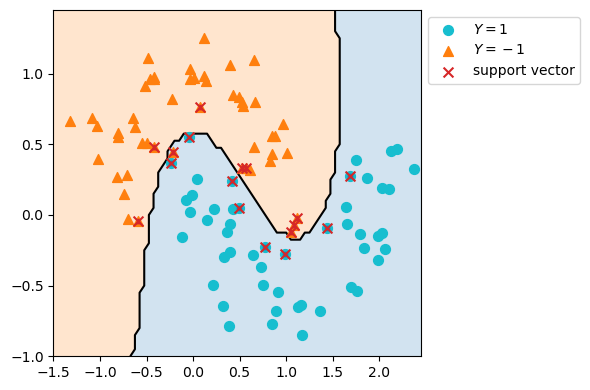

[[49  1]
 [ 0 50]]


In [9]:
# 決定関数の定数項 A0
A0 = 0.0
count = 0
for n in range(N):
    if (lamb[n] > 0)*(lamb[n] < gamma):
        count += 1
        for k in range(N):
            A0 += Y[k] - np.exp(-c*np.sum((X[n]-X[k])**2))*Y[k]*lamb[k]

A0 /= count
print(A0)

# 決定関数の予測値
Ypred = np.zeros(N)
count = 0
for n in range(N):
    for k in range(N):
        Ypred[n] += np.exp(-c*np.sum((X[n]-X[k])**2))*Y[k]*lamb[k]
Ypred += A0
Ypred = np.sign(Ypred)

# その他のデータの予測値
x1mesh = np.arange(-1.5, 2.5, 0.05)
x2mesh = np.arange(-1, 1.5, 0.05)
x1mesh, x2mesh = np.meshgrid(x1mesh, x2mesh)
Xmesh = np.hstack([x1mesh.ravel().reshape(-1, 1), x2mesh.ravel().reshape(-1, 1)])
Ymesh = np.zeros(Xmesh.shape[0])
for n in range(Xmesh.shape[0]):
    for k in range(N):
        Ymesh[n] += np.exp(-c*np.sum((Xmesh[n]-X[k])**2))*Y[k]*lamb[k]
Ymesh += A0
Ymesh = np.sign(Ymesh)


# scatter plot with determining curve
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X[:, 0][Y>0], X[:, 1][Y>0], marker='o', s=50, c='tab:cyan', label=r'$Y=1$')
ax.scatter(X[:, 0][Y<0], X[:, 1][Y<0], marker='^', s=50, c='tab:orange', label=r'$Y=-1$')
ax.scatter(X[:, 0][lamb>0][Y[lamb>0]>0], X[:, 1][lamb>0][Y[lamb>0]>0], s=10, c='tab:blue', marker='o', zorder=2)
ax.scatter(X[:, 0][lamb>0][Y[lamb>0]<0], X[:, 1][lamb>0][Y[lamb>0]<0], s=10, c='tab:red', marker='^', zorder=2)
ax.scatter(X[:, 0][lamb>0], X[:, 1][lamb>0], s=50, c='tab:red', marker='x', zorder=2, label='support vector')
ax.contourf(x1mesh, x2mesh, Ymesh.reshape(x1mesh.shape), levels=[-1, 0, 1], colors=['tab:orange', 'tab:blue'], alpha=0.2, zorder=-2)
ax.contour (x1mesh, x2mesh, Ymesh.reshape(x1mesh.shape), levels=[0], colors='k', zorder=-1)

ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
fig.tight_layout()
plt.show()

# きちんと判定できているか確認
print(confusion_matrix(Y, Ypred))

## 課題10-2

ドーナツ状に分布する2つのラベルのデータに対して，カーネルSVM を実行せよ．

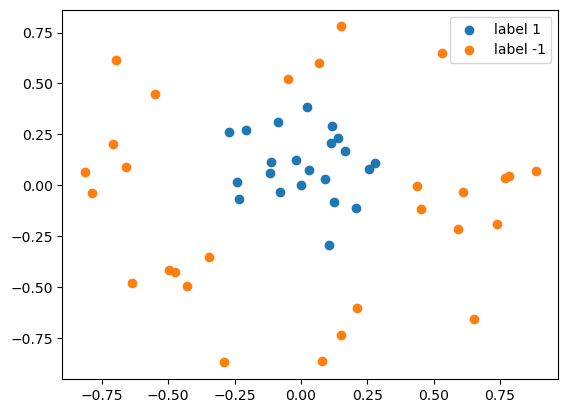

In [10]:
# サンプルサイズ
N = 50

# seed
np.random.seed(seed=1111)

### 極座標でデータを生成 ###
# 動径方向
R = np.random.rand(N)

# 回転角方向
T = np.random.rand(N)*2.0*np.pi

# 極座標
X = np.zeros((N, 2))
X[:, 0] = R*np.cos(T)
X[:, 1] = R*np.sin(T)

# 半径が 0.4 以下がラベル1, それ以外は -1
Y = np.ones(N)
Y[R>0.4] = -1

plt.scatter(X[:, 0][Y== 1], X[:, 1][Y== 1], label='label 1')
plt.scatter(X[:, 0][Y==-1], X[:, 1][Y==-1], label='label -1')
plt.legend()

# あとはカーネルSVMを実行してみせよ．

## 以上